**Student Name**: Phil Miesle

**Student ID**: 23287012

# Task

Open a new Jupyter notebook and name it etivity3_classification.ipynb. 

* In this notebook, first of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. 
* Then train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`. 

**Requirements:**

* For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.
* You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
* For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
* Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
* Summarise your experience in a markdown cell (max 150 words in a markdown cell).

## Dataset

https://www.kaggle.com/datasets/mirichoi0218/insurance

**Columns**

* age: age of primary beneficiary
* sex: insurance contractor gender, female, male
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: Individual medical costs billed by health insurance

In [1]:
import pandas as pd
df = pd.read_csv('insurance.csv')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


age  gender     bmi  children smoker     region  insurance_cost
0      18    male  33.770         1     no  southeast      1725.55230
1      18    male  34.100         0     no  southeast      1137.01100
2      18  female  26.315         0     no  northeast      2198.18985
3      18  female  38.665         2     no  northeast      3393.35635
4      18  female  35.625         0     no  northeast      2211.13075
...   ...     ...     ...       ...    ...        ...             ...
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

[1338 rows x 7 columns]

# Data Preparation

## Compute `insurance_cost_binary`

From my read of this, we are computing this on the data frame as input, rather than engineering a feature from it. And we are replacing the column, so in the end we're losing the `insurance_cost` float.

In [2]:
median_insurance_cost = df['insurance_cost'].median()
df['insurance_cost_binary'] = (df['insurance_cost'] > median_insurance_cost).astype(int)
df.drop(columns='insurance_cost', inplace=True)

In [3]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1338 non-null   int64  
 1   gender                 1338 non-null   object 
 2   bmi                    1338 non-null   float64
 3   children               1338 non-null   int64  
 4   smoker                 1338 non-null   object 
 5   region                 1338 non-null   object 
 6   insurance_cost_binary  1338 non-null   int32  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 68.1+ KB
None


age  gender     bmi  children smoker     region  insurance_cost_binary
0      18    male  33.770         1     no  southeast                      0
1      18    male  34.100         0     no  southeast                      0
2      18  female  26.315         0     no  northeast                      0
3      18  female  38.665         2     no  northeast                      0
4      18  female  35.625         0     no  northeast                      0
...   ...     ...     ...       ...    ...        ...                    ...
1333   64  female  31.825         2     no  northeast                      1
1334   64  female  26.885         0    yes  northwest                      1
1335   64    male  26.410         0     no  northeast                      1
1336   64    male  36.960         2    yes  southeast                      1
1337   64    male  23.760         0    yes  southeast                      1

[1338 rows x 7 columns]

## Data Analysis

First we need to avoid leaking test data into our training dataset. 

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1618, shuffle=True, stratify=df['insurance_cost_binary'])

And now we need to split into `X` and `y` as we're only wanting to do transformations on features.

In [5]:
X_train = train_df.drop('insurance_cost_binary', axis=1)
y_train = train_df['insurance_cost_binary']

X_test = test_df.drop('insurance_cost_binary', axis=1)
y_test = test_df['insurance_cost_binary']

A cursory data analysis; columns seem to have values which is great (no imputation!)

In [6]:
print(X_train.info())
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 1222 to 1068
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   gender    1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 58.5+ KB
None


age          bmi     children
count  1070.000000  1070.000000  1070.000000
mean     39.270093    30.582603     1.108411
std      14.034467     6.124101     1.210889
min      18.000000    16.815000     0.000000
25%      26.250000    26.185000     0.000000
50%      39.000000    30.300000     1.000000
75%      51.000000    34.496250     2.000000
max      64.000000    53.130000     5.000000

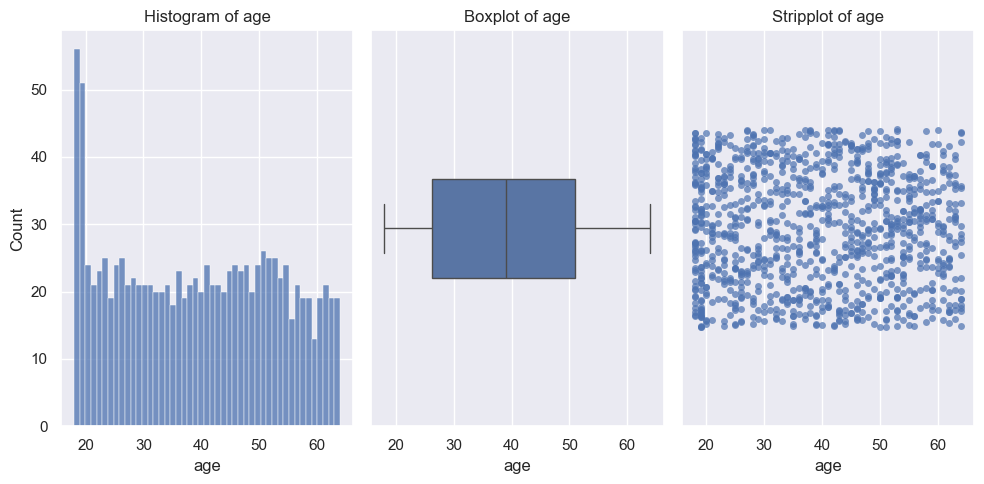

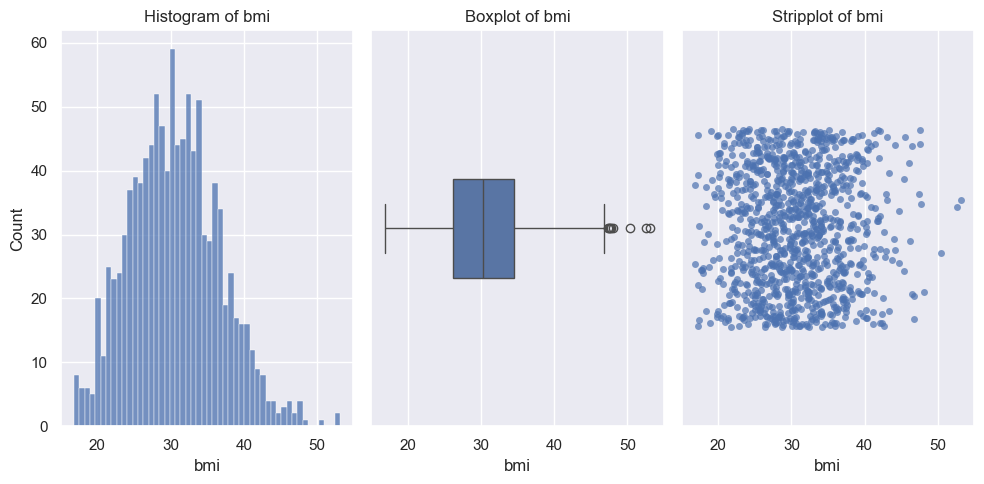

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

def hist_box_strip(col, dataframe=X_train):
    # Create a figure and a set of subplots
    _, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    unique_values = dataframe[col].nunique()
    bins = min(50, unique_values)

    if pd.api.types.is_numeric_dtype(dataframe[col]):
        unique_values = dataframe[col].nunique()
        bins = min(50, unique_values)
        sns.histplot(dataframe[col], bins=bins, ax=axs[0])
    else:
        sns.countplot(x=col, data=dataframe, ax=axs[0])
        axs[0].tick_params(axis='x', rotation=90)

    axs[0].set_title(f'Histogram of {col}')
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Count')

    valid_values = dataframe[col].dropna()
       
    if pd.api.types.is_numeric_dtype(valid_values):
        sns.boxplot(x=valid_values, ax=axs[1], width=0.25) 
        sns.stripplot(x=valid_values, jitter=0.25, ax=axs[2], alpha=0.7)
    else:
        valid_values_codes = valid_values.cat.codes
        sns.boxplot(x=valid_values_codes, ax=axs[1], width=0.25) 
        sns.stripplot(x=valid_values_codes, jitter=0.25, ax=axs[2], alpha=0.7)
        axs[1].set_xticklabels([])
        axs[2].set_xticklabels([])

    axs[1].set_title(f'Boxplot of {col}')
    axs[1].set_xlabel(col)

    axs[2].set_title(f'Stripplot of {col}')
    axs[2].set_xlabel(col)

    plt.tight_layout()
    plt.show()

for numcol in ['age','bmi']:
    hist_box_strip(numcol, X_train)


Age has a heavy skew to the left with a dip in the mid-to-late 30's; BMI is fairly normally distributed.

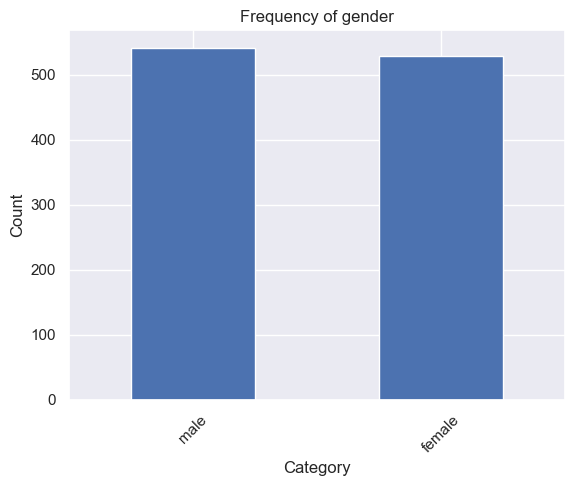

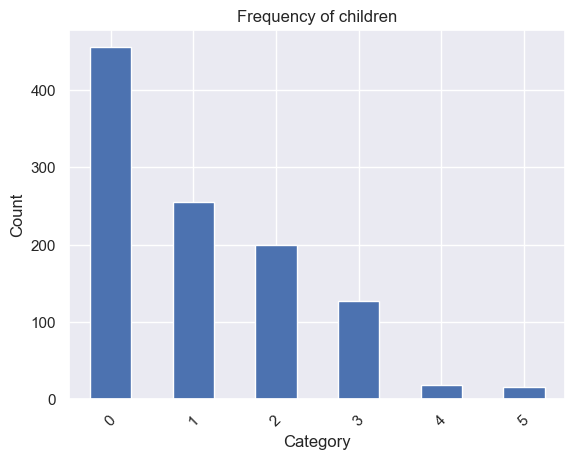

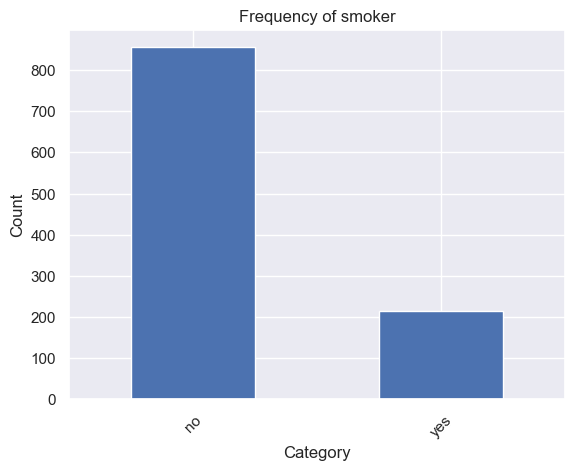

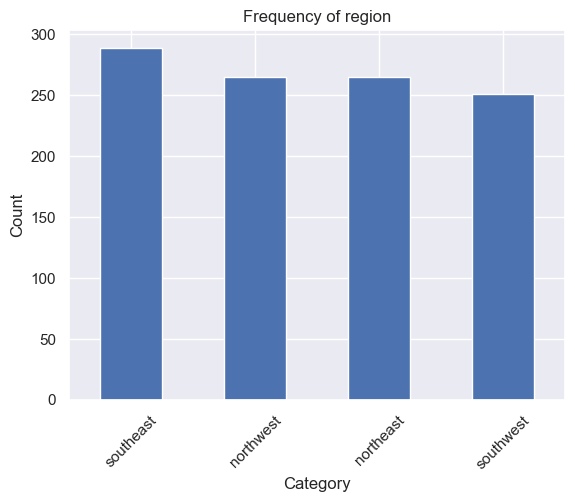

In [8]:
def hist(col, dataframe=X_train):
    value_counts = dataframe[col].value_counts()
    
    value_counts.plot(kind='bar')
    plt.title(f'Frequency of {col}')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

for catcol in ['gender','children','smoker','region']:
    hist(catcol, X_train)

## Data Preparation

For the classification step, we're using machine learning which will prefer Gaussian / uniform distributions of data, so let's see what we can do...

### `age`

`age` is skewed left, we'll aim to flatten this with a quantile binning approach.

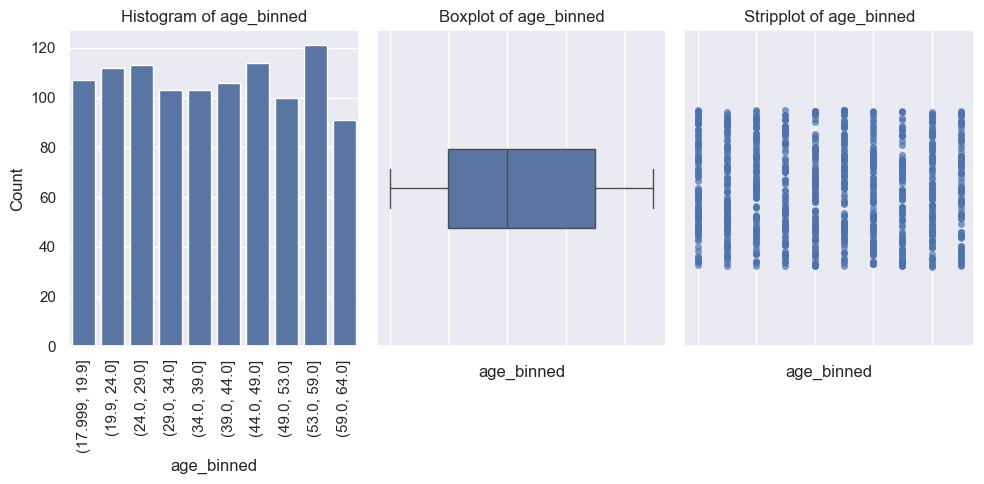

In [9]:
df_new_age = X_train[['age']].copy()
df_new_age['age_binned'] = pd.qcut(df_new_age['age'], q=10)
hist_box_strip('age_binned',df_new_age)

While not perfectly uniform, it's certainly more uniform than it was previously.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

class QuantileBinner(BaseEstimator, TransformerMixin):
    def __init__(self, n_quantiles=10):
        self.n_quantiles = n_quantiles
        self.bins = None
        
    def fit(self, X, y=None):
        self.bins = pd.qcut(X.squeeze(), q=self.n_quantiles, retbins=True, duplicates='drop')[1]
        return self

    def transform(self, X):
        return pd.cut(X.squeeze(), bins=self.bins, labels=False, include_lowest=True).to_frame()

def create_age_pipeline():
    age_pipeline = Pipeline([
        ('quantile_binner', QuantileBinner(n_quantiles=10)),
        ('encoder', OneHotEncoder(categories='auto', drop='first'))
    ])
    return age_pipeline

### `bmi`

The distribution of BMI looks Gaussian-ish but we need to center and address outliers.

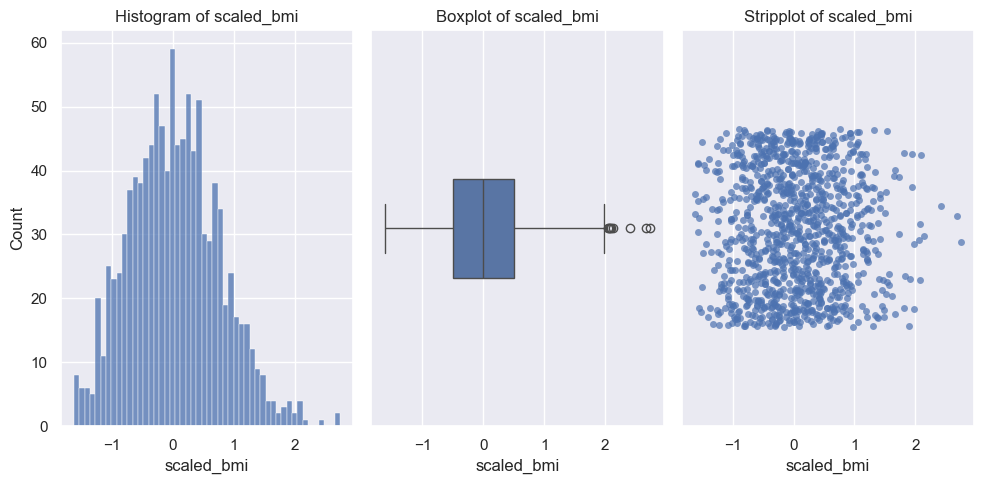

In [11]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_bmi = scaler.fit_transform(X_train[['bmi']])
scaled_bmi_df = pd.DataFrame(scaled_bmi, columns=['scaled_bmi'])
hist_box_strip('scaled_bmi', scaled_bmi_df)

### `children`

Here we'll just apply a capping function to squeeze the records with more than 3 children into a "3+" category.

In [12]:
class CapFeature(BaseEstimator, TransformerMixin):
    def __init__(self, max_val=3):
        self.max_val = max_val
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)
        return X.clip(upper=self.max_val).to_numpy()

### Other features

We can just one-hot encode the remaining features.

## Preprocessing Pipeline

In [13]:
from sklearn.compose import ColumnTransformer

def create_preprocessing_pipeline():
    age_pipeline=create_age_pipeline()
    
    pipeline = ColumnTransformer(
        transformers=[
            ('age', age_pipeline, ['age']),
            ('bmi', RobustScaler(), ['bmi']),
            ('children', CapFeature(3), ['children']),
            ('one_hot', OneHotEncoder(drop='first'), ['gender','smoker','region']),
        ],
        remainder='passthrough'
    )
    return pipeline

preprocessing_pipeline = create_preprocessing_pipeline()

In [14]:
preprocessing_pipeline.fit(X_train)
X_transformed = preprocessing_pipeline.transform(X_train)

In [15]:
X_transformed

<1070x16 sparse matrix of type '<class 'numpy.float64'>'
	with 4206 stored elements in Compressed Sparse Row format>

So `X_transformed` is in the compact (sparse) representation format, which means we can't easily inspect it. I noted that we can do `.set_output(transform="pandas")` but that isn't really properly implemented as a software interface/specification and I really can't afford the time to go down the rabbit hole on that particular one. I don't really need to understand what column is what anyhow...

In [16]:
X_transformed_df = pd.DataFrame(X_transformed.toarray())

In [17]:
X_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1070 non-null   float64
 1   1       1070 non-null   float64
 2   2       1070 non-null   float64
 3   3       1070 non-null   float64
 4   4       1070 non-null   float64
 5   5       1070 non-null   float64
 6   6       1070 non-null   float64
 7   7       1070 non-null   float64
 8   8       1070 non-null   float64
 9   9       1070 non-null   float64
 10  10      1070 non-null   float64
 11  11      1070 non-null   float64
 12  12      1070 non-null   float64
 13  13      1070 non-null   float64
 14  14      1070 non-null   float64
 15  15      1070 non-null   float64
dtypes: float64(16)
memory usage: 133.9 KB


# Classification without Reduction

## SVM

In [18]:
# Code is from Tutorial 3-1 Binary Classification.ipynb
from sklearn import svm

svm_pipe = Pipeline(steps=[
    ('preprocess', create_preprocessing_pipeline()), 
    ('svm', svm.SVC(probability=True))
])

In [19]:
# Code is from Tutorial 3-1 Binary Classification.ipynb
from sklearn import set_config
set_config(display="diagram")
svm_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('quantile_binner',
                                                                   QuantileBinner()),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['age']),
                                                 ('bmi', RobustScaler(),
                                                  ['bmi']),
                                                 ('children', CapFeature(),
                                                  ['children']),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('svm', SVC(probability=True))])

In [20]:
# Code is from Tutorial 3-1 Binary Classification.ipynb
from sklearn.model_selection import GridSearchCV

svm_param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
}

SVM_search = GridSearchCV(svm_pipe, svm_param_grid, n_jobs=-1, cv=5, refit=True)
SVM_search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % SVM_search.best_score_)
print("Best parameters: ", SVM_search.best_params_)

# store the best params and best model for later use
SVM_best_params = SVM_search.best_params_
SVM_best_model = SVM_search.best_estimator_

Best CV score = 0.925:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


## Random Forest

In [21]:
# Code is from Tutorial 3-1 Binary Classification.ipynb
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ('preprocess', create_preprocessing_pipeline()), 
    ('rf', RandomForestClassifier())])

In [22]:
rf_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('quantile_binner',
                                                                   QuantileBinner()),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['age']),
                                                 ('bmi', RobustScaler(),
                                                  ['bmi']),
                                                 ('children', CapFeature(),
                                                  ['children']),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('rf', RandomForestClassifier())])

In [23]:
rf_param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8],
}

RF_search = GridSearchCV(rf_pipe, rf_param_grid, n_jobs=-1, cv=5, refit=True)
RF_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % RF_search.best_score_)
print("Best parameters: ", RF_search.best_params_)

# store the best params and best model for later use
RF_best_params = RF_search.best_params_
RF_best_model = RF_search.best_estimator_

Best CV score = 0.920:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


## MLPClassifier

In [24]:
from sklearn.neural_network import MLPClassifier

mlp_pipe = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('mlp', MLPClassifier(max_iter=1000)) 
])

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],  # One and two layer architectures
    'mlp__activation': ['tanh', 'relu'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01],
}

MLP_search = GridSearchCV(mlp_pipe, mlp_param_grid, n_jobs=-1, cv=5, refit=True)
MLP_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % MLP_search.best_score_)
print("Best parameters: ", MLP_search.best_params_)

# Store the best params and best model for later use
MLP_best_params = MLP_search.best_params_
MLP_best_model = MLP_search.best_estimator_

Best CV score = 0.921:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001}


# Classifier with Feature Reduction

Using feature reduction with such a small number of features seems unnecessary but it is a learning exercise so we'll proceed! But in a sort of protest, I'm going to see if I can figure out how add the feature reduction parameters as part of the grid search ;)

In [35]:
from sklearn.preprocessing import FunctionTransformer

# PCA doesn't like sparse arrays, so given the small dataset I will throw a converter into the pipeline
def to_dense(X):
    return X.toarray()

# Set the dimensionality reduction options on the search grid
num_features = X_transformed.shape[1]
reduce_dim_options = [int(num_features * frac) for frac in [1/4, 1/2, 3/4]]

## SVM

`FeatureUnion` allows us to combine features reduction into a single pipeline, similar to the [Scikit Learn docs](https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html#sphx-glr-download-auto-examples-compose-plot-feature-union-py):

In [37]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.svm import SVC

features_svm_pipe = Pipeline(steps=[
    ('preprocess', create_preprocessing_pipeline()), 
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)), 
    ('reduce_dim', FeatureUnion([
            ('pca', PCA(iterated_power=7)),
            ('rfe', RFE(estimator=SVC(kernel="linear"))),
            ('select_best', SelectKBest())
        ])),
    ('svm', svm.SVC(probability=True))
])

features_svm_param_grid = svm_param_grid | {
    'reduce_dim__pca__n_components': reduce_dim_options,
    'reduce_dim__rfe__n_features_to_select': reduce_dim_options,
    'reduce_dim__select_best__k': reduce_dim_options,
}

Features_SVM_search = GridSearchCV(features_svm_pipe, features_svm_param_grid, n_jobs=-1, cv=5, refit=True)
Features_SVM_search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % Features_SVM_search.best_score_)
print("Best parameters: ", Features_SVM_search.best_params_)

# store the best params and best model for later use
Features_SVM_best_params = Features_SVM_search.best_params_
Features_SVM_best_model = Features_SVM_search.best_estimator_

Best CV score = 0.925:
Best parameters:  {'reduce_dim__pca__n_components': 12, 'reduce_dim__rfe__n_features_to_select': 12, 'reduce_dim__select_best__k': 4, 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [40]:
features_svm_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('quantile_binner',
                                                                   QuantileBinner()),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['age']),
                                                 ('bmi', RobustScaler(),
                                                  ['bmi']),
                                                 ('children', CapFeature(),
                                                  ['children']),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function to_dense at 0x000001E5C9BDC220>)),
                ('reduce_dim',
                 FeatureUnion(transformer_list=[('pca', PCA(iterated_power=7)),
                                                ('rfe',
                                                 RFE(estimator=SVC(kernel='linear'))),
                                                ('select_best',
                                                 SelectKBest())])),
                ('svm', SVC(probability=True))])

## Random Forest

The "Tutorial 3-2" notebook doesn't combine the feature reduction steps, but rather uses a search grid to find a single dimension reduction that performs best:

In [36]:
features_rf_pipe = Pipeline([
    ('preprocess', create_preprocessing_pipeline()), 
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)), 
    ('reduce_dim', 'passthrough'),
    ('rf', RandomForestClassifier())
])

features_rf_param_grid = [
    rf_param_grid | {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': reduce_dim_options,
    },
    rf_param_grid | {
        'reduce_dim': [RFE(estimator=SVC(kernel="linear"))],
        'reduce_dim__n_features_to_select': reduce_dim_options,
    },
    rf_param_grid | {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': reduce_dim_options,
    },
    rf_param_grid | {
        'reduce_dim': ['passthrough'],
    }
]

Features_RF_search = GridSearchCV(features_rf_pipe, features_rf_param_grid, n_jobs=-1, cv=5, refit=True)
Features_RF_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % Features_RF_search.best_score_)
print("Best parameters: ", Features_RF_search.best_params_)

# Store the best params and best model for later use
Features_RF_best_params = Features_RF_search.best_params_
Features_RF_best_model = Features_RF_search.best_estimator_

Best CV score = 0.919:
Best parameters:  {'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 12, 'rf__max_depth': 8, 'rf__n_estimators': 20}


In [41]:
features_rf_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('quantile_binner',
                                                                   QuantileBinner()),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['age']),
                                                 ('bmi', RobustScaler(),
                                                  ['bmi']),
                                                 ('children', CapFeature(),
                                                  ['children']),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function to_dense at 0x000001E5C9BDC220>)),
                ('reduce_dim', 'passthrough'),
                ('rf', RandomForestClassifier())])

## MLP Classifier

Here let's go back to the combined features, but remain with a sparse array – this means we'll drop PCA, but let's also use a different estimator:

In [38]:
from sklearn.feature_selection import RFECV

features_mlp_pipe = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('reduce_dim', FeatureUnion([
            ('rfecv', RFECV(estimator=SVC(kernel="linear"))),
            ('select_best', SelectKBest())
        ])),
    ('mlp', MLPClassifier(max_iter=1000)) 
])

features_mlp_param_grid = mlp_param_grid | {
    'reduce_dim__rfecv__min_features_to_select': reduce_dim_options,
    'reduce_dim__select_best__k': reduce_dim_options,
}

Features_MLP_search = GridSearchCV(features_mlp_pipe, features_mlp_param_grid, n_jobs=-1, cv=5, refit=True)
Features_MLP_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % Features_MLP_search.best_score_)
print("Best parameters: ", Features_MLP_search.best_params_)

# Store the best params and best model for later use
Features_MLP_best_params = Features_MLP_search.best_params_
Features_MLP_best_model = Features_MLP_search.best_estimator_

Best CV score = 0.915:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': 0.001, 'reduce_dim__rfecv__min_features_to_select': 12, 'reduce_dim__select_best__k': 12}


In [42]:
features_mlp_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('quantile_binner',
                                                                   QuantileBinner()),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['age']),
                                                 ('bmi', RobustScaler(),
                                                  ['bmi']),
                                                 ('children', CapFeature(),
                                                  ['children']),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('reduce_dim',
                 FeatureUnion(transformer_list=[('rfecv',
                                                 RFECV(estimator=SVC(kernel='linear'))),
                                                ('select_best',
                                                 SelectKBest())])),
                ('mlp', MLPClassifier(max_iter=1000))])

## Save Grid Searches for Future Use

In [39]:
import pickle

grid_searches = [SVM_search, Features_SVM_search, RF_search, Features_RF_search, MLP_search, Features_MLP_search]
with open('grid_searches.pkl', 'wb') as file:
    pickle.dump(grid_searches, file)